In [ ]:
pip install torch==1.6.0 torchvision==0.7.0

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).



len(dataloader) is:469


epoch 1 of 10,Step 500: Generator loss: -0.4476504802238196, critic loss: -64.35687707767191

len(dataloader) is:469


epoch 2 of 10,Step 1000: Generator loss: 40.12209374207258, critic loss: -407.40027574157693

len(dataloader) is:469


epoch 3 of 10,Step 1500: Generator loss: 125.8987661819458, critic loss: -846.4061603027346

len(dataloader) is:469


epoch 4 of 10,Step 2000: Generator loss: 191.52468490600586, critic loss: -1303.681107824707


KeyboardInterrupt: ignored

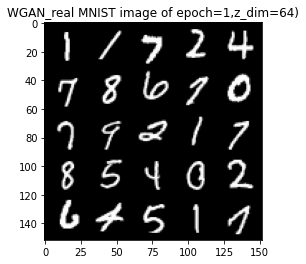

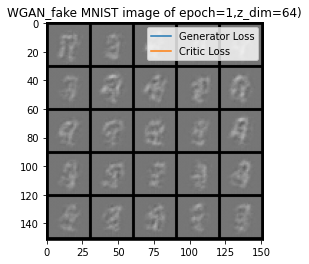

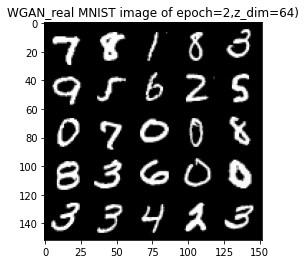

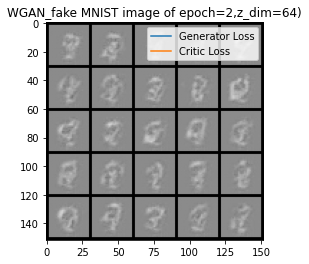

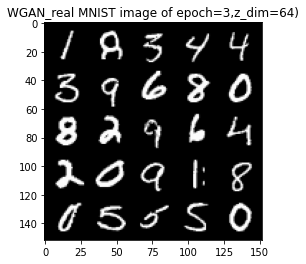

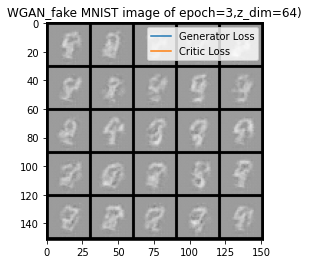

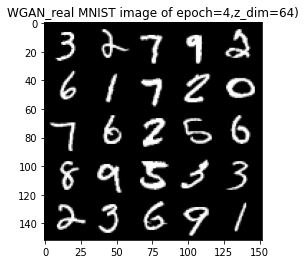

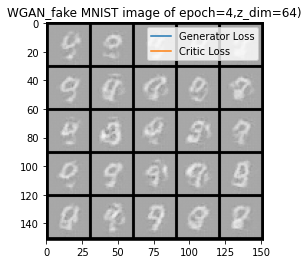

In [6]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pandas import DataFrame
import pandas as pd
from pandas import ExcelWriter
import time
from matplotlib.backends.backend_pdf import PdfPages
from google.colab import drive
drive.mount('/content/drive/')

torch.manual_seed(0)

def show_tensor_images(image_tensor, title, num_images=25,size=(1,28,28)):
    image_tensor = (image_tensor+1)/2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.figure()
    plt.title(title)
    plt.imshow(image_grid.permute(1,2,0).squeeze())

def multipage(filename,figs=None,dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp,format='pdf')
    pp.close()


def make_grad_hook():
    grads = []
    def grad_hook(m):
        if isinstance(m,nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook

class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator,self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(self.make_gen_block(z_dim,hidden_dim*4), self.make_gen_block(hidden_dim*4,hidden_dim*2,kernel_size=4, stride=1),
                                self.make_gen_block(hidden_dim*2,hidden_dim), self.make_gen_block(hidden_dim,im_chan,kernel_size=4,final_layer=True))
    def make_gen_block(self,input_channels, output_channels,kernel_size=3,stride=2,final_layer=False):
        if not final_layer:
            return nn.Sequential(nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),
                                 nn.BatchNorm2d(output_channels),
                                 nn.ReLU(inplace=True))
        else:
            return nn.Sequential(nn.ConvTranspose2d(input_channels,output_channels,kernel_size,stride),nn.Tanh(),)
    def forward(self,noise):
        x = noise.view(len(noise),self.z_dim,1,1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

class Critic(nn.Module):
    def __init__(self,im_chan=1,hidden_dim=64):
        super(Critic,self).__init__()
        self.crit = nn.Sequential(self.make_crit_block(im_chan,hidden_dim),
                                   self.make_crit_block(hidden_dim, hidden_dim*2),
                                   self.make_crit_block(hidden_dim*2,1,final_layer=True))
    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                                 nn.BatchNorm2d(output_channels), nn.LeakyReLU(0.2, inplace=True))
        else:
            return nn.Sequential(nn.Conv2d(input_channels, output_channels, kernel_size, stride))
    def forward(self, image):
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight,0,0.2)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight,0,0.02)
        torch.nn.init.constant_(m.bias,0)


def get_gradient(crit, real, fake, epsilon):
    mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_scores = crit(mixed_images)
    gradient = torch.autograd.grad(inputs=mixed_images, outputs=mixed_scores,grad_outputs=torch.ones_like(mixed_scores),create_graph=True, retain_graph=True,)[0]
    return gradient

def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient),-1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm-1)**2)
    return penalty

def get_gen_loss(crit_fake_pred):
    gen_loss = -torch.mean(crit_fake_pred)
    return gen_loss

def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    crit_loss = -(torch.mean(crit_real_pred)-torch.mean(crit_fake_pred))+c_lambda*gp
    return crit_loss

start_time = time.time()
batch_size =128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999 
c_lambda = 10
crit_repeats = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,)),])
dataloader = DataLoader(MNIST('.',download=True, transform=transform), batch_size=batch_size, shuffle=True)
generator_losses = []
critic_losses = []
acc_gen_loss = 0
acc_critic_loss = 0
data_list = []
list_crit=[]
list_gen=[]
cur_step=0
display_step=500
gen_list=[]
critic_list=[]
gen_mean = 0
crit_mean=0

n_epochs = 10
z_dims = [64]

for z_dim in z_dims:
    gen = Generator(z_dim).to(device)
    gen_opt = torch.optim.Adam(gen.parameters(),lr=lr,betas=(beta_1,beta_2))
    crit = Critic().to(device)
    crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1,beta_2))
    gen = gen.apply(weights_init)
    crit = crit.apply(weights_init)

    for epoch in range(n_epochs):
        load_num = 0
        for real, _ in tqdm(dataloader):
            cur_batch_size = len(real)
            real = real.to(device)
            mean_iteration_critic_loss = 0
            for _ in range(crit_repeats):
                crit_opt.zero_grad()
                fake_noise = get_noise(cur_batch_size, z_dim, device)
                fake = gen(fake_noise)
                crit_fake_pred = crit(fake.detach())
                crit_real_pred = crit(real)
                epsilon = torch.rand(len(real),1,1,1,device=device,requires_grad=True)
                gradient = get_gradient(crit,real,fake.detach(),epsilon)
                gp = gradient_penalty(gradient)
                crit_loss = get_crit_loss(crit_fake_pred,crit_real_pred,gp,c_lambda)
            
                mean_iteration_critic_loss += crit_loss.item()/crit_repeats

                crit_loss.backward(retain_graph=True)
                crit_opt.step()

            list_crit += [mean_iteration_critic_loss]

            acc_critic_loss += mean_iteration_critic_loss
            gen_opt.zero_grad()
            fake_noise_2 = get_noise(cur_batch_size, z_dim, device)
            fake_2 = gen(fake_noise_2)
            crit_fake_pred = crit(fake_2)
            gen_loss = get_gen_loss(crit_fake_pred)
            gen_loss.backward()
            gen_opt.step()
            acc_gen_loss += gen_loss.item()
            list_gen += [gen_loss.item()]
            load_num += 1

            ### Visualization code ###
            if cur_step % display_step == 0 and cur_step > 0:
                gen_mean = sum(list_gen[-display_step:]) / display_step
                crit_mean = sum(list_crit[-display_step:]) / display_step
                print(f"epoch {epoch} of {n_epochs},Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
                step_bins = 20
                num_examples = (len(generator_losses) // step_bins) * step_bins
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Generator Loss"
                )
                plt.plot(
                    range(num_examples // step_bins), 
                    torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                    label="Critic Loss"
                )
                plt.legend()
            cur_step+=1
            gen_list.append(gen_mean)
            critic_list.append(crit_mean)

        mean_critic_loss = acc_critic_loss/(load_num)
        mean_critic_loss = round(mean_critic_loss,2)
        mean_gen_loss = acc_gen_loss/(load_num)
        mean_gen_loss = round(mean_gen_loss,2)
        print(f'len(dataloader) is:{len(dataloader)}')
        critic_losses.append(mean_critic_loss)
        generator_losses.append(mean_gen_loss)
        data_list.append([epoch,z_dim,mean_critic_loss,mean_gen_loss])

        if epoch%1==0:
            show_tensor_images(real,'WGAN_real MNIST image of epoch='+str(epoch+1)+',z_dim='+str(z_dim)+')')
            show_tensor_images(fake,'WGAN_fake MNIST image of epoch='+str(epoch+1)+',z_dim='+str(z_dim)+')')


    plt.figure()
    plt.title('WGAN MNIST EMD (n_epochs='+str(n_epochs)+',z_dim='+str(z_dim)+')')
    plt.plot(range(1,n_epochs+1),gen_list,color='blue',label='generator')
    plt.plot(range(1,n_epochs+1),critic_list,color='red',label='critic')
    plt.xlabel('epoch')
    plt.ylabel('EMD')
    plt.legend()
    generator_losses=[]
    critic_losses=[]

print(f'WGAN size of generator_losses is:{len(generator_losses)}, size of critic_losses is: {len(critic_losses)}')
print(f'WGAN generator_losses is:{generator_losses}, critic_losses is: {critic_losses}')
print(f'load number: {load_num}')

data_df = pd.DataFrame(data_list)
data_df.columns=['epoch','z_dim','generator_loss','critic_loss']

with ExcelWriter('/content/drive/My Drive/WGAN_MNIST/WGAN_MNIST_output_table.xlsx',engine='openpyxl',mode='a') as writer:
    data_df.to_excel(writer,index=False)
    writer.save()

multipage('/content/drive/My Drive/WGAN_MNIST/WGAN MNIST record(n_epochs='+str(n_epochs)+',z_dim='+str(z_dim)+')')


total_time = time.time()-start_time
total_time = round(total_time/60,2)

with open('/content/drive/My Drive/WGAN_MNIST/record for WGAN MNIST.txt','a') as to_file:
    to_file.write('\n')
    to_file.write('WGAN MNIST record(n_epochs='+str(n_epochs)+',z_dim='+str(z_dim)+')')
    to_file.write('\n')
    to_file.write('total runing time(minutes) is:'+str(total_time))
    to_file.close()

print(f'stop training, total WGAN for MNIST time(minutes) is:{total_time}')
'''
print(f'lis_crit:{list_gen}, list_gen:{list_gen}')
print(f'lis_crit2:{list_gen2}, list_gen2:{list_gen2}')
'''

In [ ]:
list_gen